### Set Parameters

In [8]:
import math
import random
import numpy as np
import mcOCTFunctions as MOF

# Define Simulation Constants

PI = math.pi
LIGHTSPEED = 2.997925E10  # Speed of light in vacuum [cm/s]
THRESHOLD = 0.01          # Threshold weight for Roulette
CHANCE = 0.1              # Chance of survival in Roulette
COS90D = 1.0E-6           # Cosine of angle close to 90 degrees
ONE_MINUS_COSZERO = 1.0E-12  # 1 minus cosine of angle close to 0 degrees

def SIGN(x):
    """Return the sign of x."""
    return 1 if x >= 0 else -1

# Optical Properties of Tissue
mua = 1              # Absorption coefficient [cm^-1]
mus = 10             # Scattering coefficient [cm^-1]
g = 0.9             # Anisotropy factor [-]
n1 = 1               # Refractive index of ambient medium
n2 = 1.33            # Tissue refractive index

# Simulation Parameters
Nphotons = 4 # Number of photons in simulation
albedo = mus / (mus + mua) if (mus + mua) != 0 else 0  # Albedo (scattering probability)

# Input Beam Parameters
w0 = 0.003        # Beam waist (mm)
zf = 0.4         # Distance between launch plane and focus (mm)
wl = 0.8         # Wavelength (um)

# Calculate NA 
Angle = wl/(PI*w0*1000) # Angle in radians
print ("Angle = ", Angle*180/PI,'degree')


Angle =  4.863416814832214 degree


### Monte Carlo Simulation

In [9]:
seeds_coor = {} # Dictionary to store the seed and coordinates of each photon

for i_photon in range(int(Nphotons)):
    # LAUNCH and initialize photon position and trajectory for a source
    W = 1.0                    # Set initial photon weight to 1
    photon_alive = True        # Photon is alive
    escape_status = False      # Photon has not escaped
    
    # Initialize random number generator for this photon
    seed = i_photon
    rng = random.Random(seed)  

    # Pick a light source
    x,y,z,ux,uy,uz =MOF.Gaussian_FBEAM(w0, zf, wl, rng)
    # print()
    # print ("Photon ", i_photon, " launched at =", x, y, z,"at angle =", ux, uy, uz)

    # Record the photon position
    seeds_coor[seed] = []
    seeds_coor[seed].append((seed, x, y, z))           # Store the initial position of the photon

    counter = 0
 
    # MOVE(Bounce)_DROP_SPIN_CHECK. Propagate the photon until it dies
    while photon_alive:
        # MOVE
        x, y, z, ux, uy, uz,s,photon_alive, escape_status = MOF.MOVE(x, y, z, ux, uy, uz, mua, mus,rng, photon_alive, escape_status, n1, n2)
        counter += 1
        #print ( "At step", counter, "Photon ", i_photon, " moved to ", x, y, z, " with s = ", s , "with ux, uy, uz = ", ux, uy, uz)
        #print()


        # Track photon position. If photon escapes, store exit position and direction at the end
        if escape_status:
            seeds_coor[seed].append((seed, x, y, z,ux, uy, uz))   # Store the exit position and direction of the photon
        else:
            seeds_coor[seed].append((seed, x, y, z,s))            # Store the position of the photon

        # DROP
        W = MOF.DROP(W, albedo)

        # SPIN
        ux, uy, uz = MOF.SPIN(ux, uy, uz, g, rng)
       # print ("After SPIN, ux, uy, uz = ", ux, uy, uz)
        

        # CHECK ROULETTE
        # Apply Roulette technique if photon weight is below threshold
        if W < THRESHOLD:
            if  random.random() <= CHANCE:
                W /= CHANCE          # Survives with increased weight
            else:
                photon_alive =False  # Photon is terminated

### Test

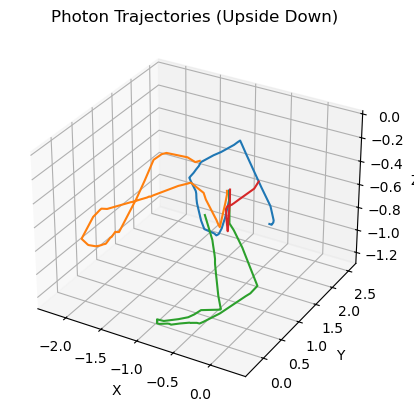

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for seed in range(4):
    coords = seeds_coor[seed]
    x_vals = [coord[1] for coord in coords]
    y_vals = [coord[2] for coord in coords]
    z_vals = [coord[3] for coord in coords]
    ax.plot(x_vals, y_vals, [-z for z in z_vals], label=f'Photon {seed}')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Photon Trajectories (Upside Down)')
plt.show()


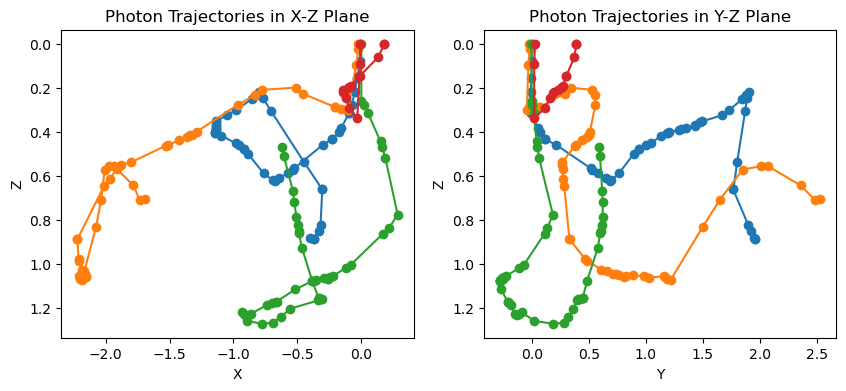

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # Two subplots side by side
for seed in range(4):
    coords = seeds_coor[seed]
    x_vals = [coord[1] for coord in coords]
    y_vals = [coord[2] for coord in coords]
    z_vals = [coord[3] for coord in coords]  # Invert the z-axis values
    ax1.plot(x_vals, z_vals, '-o')
    ax2.plot(y_vals, z_vals, '-o')

ax1.set_xlabel('X')
ax1.set_ylabel('Z')
ax1.set_title('Photon Trajectories in X-Z Plane')
ax1.invert_yaxis()  # Invert the Z-axis to maintain the same visual appearance

ax2.set_xlabel('Y')
ax2.set_ylabel('Z')
ax2.set_title('Photon Trajectories in Y-Z Plane')
ax2.invert_yaxis()  # Invert the Z-axis to maintain the same visual appearance
plt.show()




### Note
- When plot the photons reflected at the boundary, the line plot is not correct as it connect the last position to the reflected photon position and skill the reflected trace. 
- If simulate no scattering situations, g= +/- 1 
